# Imports

In [36]:
# !pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [37]:
#Librerias
import numpy as np
import os
from pathlib import Path
from PIL import Image
import pandas as pd

#Librerías de PyTorch
import torch  #PyTorch library
from torch.utils.data import Dataset, DataLoader, sampler, random_split
import torchvision.transforms as tt

#Librerias utiles para plotear
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline 
#plots in the line below the code, inside the notebook 

import sys
sys.path.insert(0, '../')
from src.config import *

# Visualization

In [38]:
# archive of 95-Cloud Scene IDs
ids95 = pd.read_excel(Path(Cloud95_additional, '95-Cloud_SceneIDs_lat_lon.xlsx'))
ids95.head()

,SceneID,latitude,longitude,"Latitude,longitude",Unnamed: 4,Unnamed: 5,g
0,LC08_L1TP_002053_20160520_20170324_01_T1,10.12258,-63.96202,"10.12258,-63.96202",NaN,NaN,NaN
1,LC08_L1TP_002054_20160520_20170324_01_T1,8.67720,-64.27505,"8.6772,-64.27505",NaN,NaN,NaN
2,LC08_L1TP_006248_20160820_20170322_01_T1,81.33221,-20.56977,"81.33221,-20.56977",NaN,NaN,NaN
3,LC08_L1TP_007054_20170729_20170811_01_T1,8.67860,-72.01910,"8.6786,-72.0191",NaN,NaN,NaN
4,LC08_L1TP_011002_20160620_20170323_01_T1,79.99852,-19.63154,"79.99852,-19.63154",NaN,NaN,NaN


**LXSS_LLLL_PPPRRR_YYYYMMDD_yyyymmdd_CC_TX**
* L = Landsat (constant)

* X = Sensor (C = OLI / TIRS, O = OLI-only, T= TIRS-only, E = ETM+, T = TM, M= MSS)

* SS = 08 : Landsat 8

* LLLL = L1TP : Processing level, L1TP es corrección de precisión y terreno (L1TP, L1GT, L1GS)

* PPP = WRS path

* RRR = WRS row

* YYYYMMDD = Acquisition Year (YYYY) / Month (MM) / Day (DD)

* yyyymmdd = Processing Year (yyyy) / Month (mm) / Day (dd)

* CC = 01 : Collection number
* TX= RT for Real-Time, T1 for Tier 1 (highest quality), and T2 for Tier 2


Each folder contains images in **TIF** format. 

1. __Entire scenes__ (*Entire scene ground truth*): These are the masks of the entire scenes, that is, without cropping, provided by Landsat. They are images of 8000x8000 pixels in size, color 0 or 255 in RGB scale (black or white).

The folder contains 75 images.


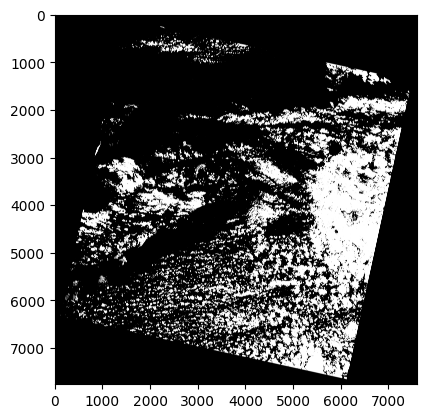

In [39]:
# Escenas enteras 
print('The folder contains ' + str(len(os.listdir(Path(Cloud95_additional, 'Entire_Scene_gts')))) + ' images.')
es_img = Image.open(Path(Cloud95_additional, 'Entire_Scene_gts/edited_corrected_gts_LC08_L1TP_002053_20160520_20170324_01_T1.TIF'))
plt.imshow(es_img)

2. __Blue band__ (*train blue*): These are non-overlapping cutouts, 384x384 pixels in size, of the entire scenes in the LANDSAT8 visible blue band. Note that each patch corresponds spatially to the same patch in the rest of the bands.

The folder contains 26301 images.


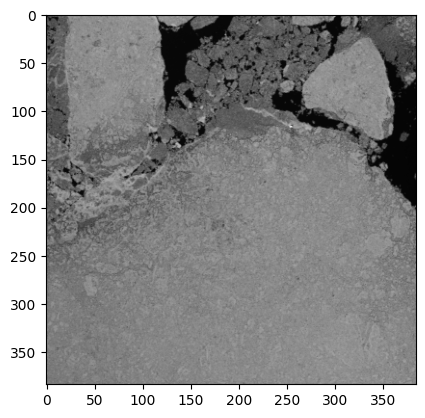

In [40]:
print('The folder contains ' + str(len(os.listdir(Path(Cloud95_additional, 'train_blue_additional_to38cloud')))) + ' images.')
blue_img = Image.open(Path(Cloud95_additional, 'train_blue_additional_to38cloud/blue_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'))
plt.imshow(blue_img, cmap='gray')

3. __Green band__ (*train green*): These are non-overlapping cutouts, 384x384 pixels in size, of the entire scenes in the visible green Landsat band. Note that each patch corresponds spatially to the same patch in the rest of the bands.

The folder contains 26301 images.


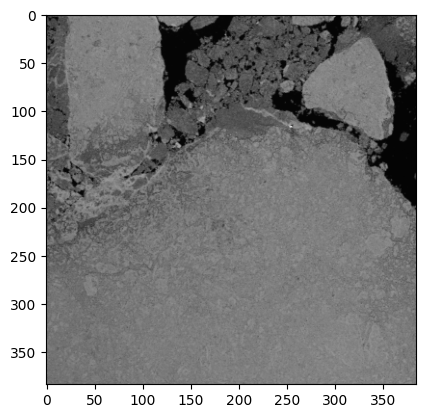

In [41]:
print('The folder contains ' + str(len(os.listdir(Path(Cloud95_additional, 'train_green_additional_to38cloud')))) + ' images.')
green_img = Image.open(Path(Cloud95_additional, 'train_green_additional_to38cloud/green_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'))
plt.imshow(green_img, 'gray')

4. __Red band__ (*train red*): These are non-overlapping cutouts, 384x384 pixels in size, of the entire scenes in the visible red band of Landsat. Note that each patch corresponds spatially to the same patch in the rest of the bands.

The folder contains 26301 images.


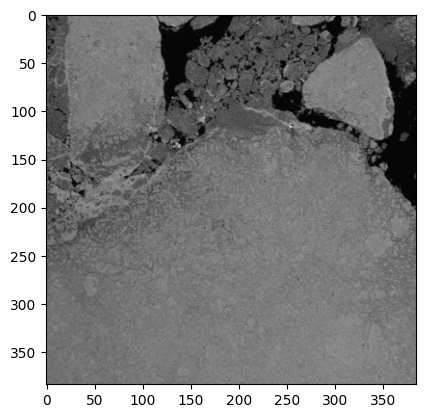

In [42]:
print('The folder contains ' + str(len(os.listdir(Path(Cloud95_additional, 'train_red_additional_to38cloud')))) + ' images.')
red_img = Image.open(Path(Cloud95_additional, 'train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'))
plt.imshow(red_img, cmap='gray')

5. __Near infrared band__ (*train nir*): These are non-overlapping cutouts, 384x384 pixels in size, of entire scenes in the Landsat near-infrared band. Note that each patch corresponds spatially to the same patch in the rest of the bands.

The folder contains 26301 images.


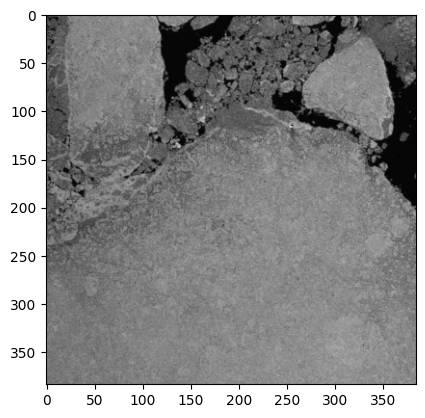

In [43]:
print('The folder contains ' + str(len(os.listdir(Path(Cloud95_additional, 'train_nir_additional_to38cloud')))) + ' images.')
nir_img = Image.open(Path(Cloud95_additional, 'train_nir_additional_to38cloud/nir_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'))
plt.imshow(nir_img, 'gray')

In [44]:
# Identification of the scene to which this clipping belongs
ids95.SceneID == 'LC08_L1TP_006248_20160820_20170322_01_T1'
print('Latitude: ' + str(ids95.latitude[2]) + '; Longitude: ' + str(ids95.longitude[2]))

Latitude: 81.33221; Longitude: -20.56977


World Reference System 2- Daytime, descending
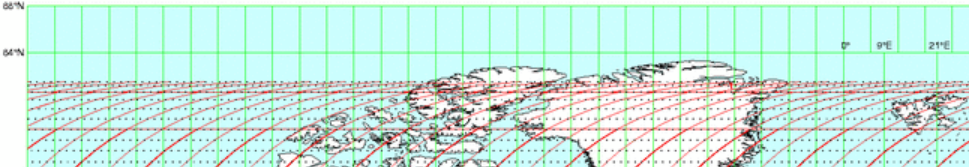

6. __Cropped masks__ (*train gt*): These are the non-overlapping cutouts, 384x384 pixels in size, of the masks of the entire scenes. They are 26301 in total.

Shape: (384, 384)
Maximum = 255 ; Minimum = 0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


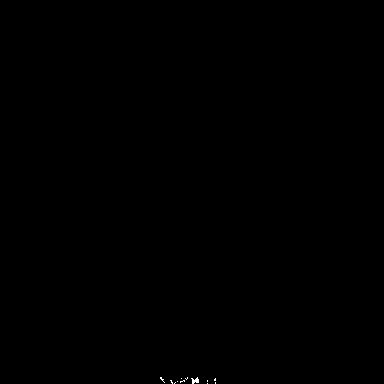

In [45]:
gt_img = Image.open(Path(Cloud95_additional, 'train_gt_additional_to38cloud/gt_patch_100_5_by_12_LC08_L1TP_047011_20160920_20170221_01_T1.TIF'))
gt_array = np.array(gt_img)
print('Shape: ' + str(gt_array.shape))
print('Maximum = ' + str(gt_array.max()) + ' ; ' + 'Minimum = ' + str(gt_array.min()))
print(gt_array)
gt_img

Finally, I show an image with the three bands combined to form an RGB image, and its respective mask. Note that they are not normalized. I choose this particular one because it contains a surface with snow and no clouds and it can be clearly seen that the mask reflects this fact.

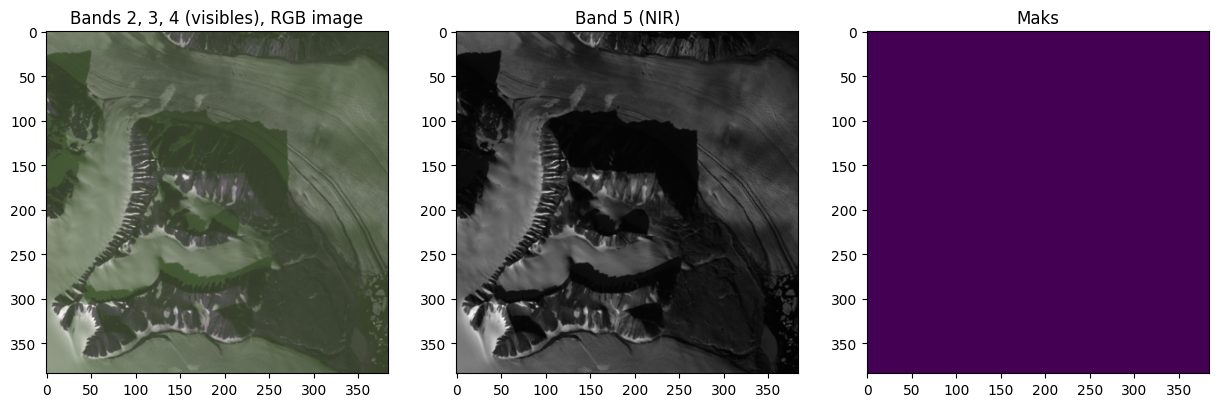

In [46]:
r = np.array(Image.open(Path(Cloud95_additional, 'train_red_additional_to38cloud/red_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')))
r = r/r.max()
g = np.array(Image.open(Path(Cloud95_additional, 'train_green_additional_to38cloud/green_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')))
g = g/g.max()
b = np.array(Image.open(Path(Cloud95_additional, 'train_blue_additional_to38cloud/blue_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')))
b = b/b.max()
rgb = np.zeros([384,384,3])
rgb[:,:,0] = g
rgb[:,:,1] = b
rgb[:,:,2] = r

plt.figure(figsize=(15,15))

plt.subplot(131)
plt.title('Bands 2, 3, 4 (visibles), RGB image')
plt.imshow(rgb)
plt.subplot(132)
plt.title('Band 5 (NIR)')
plt.imshow(Image.open(Path(Cloud95_additional, 'train_nir_additional_to38cloud/nir_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')), cmap='gray')
plt.subplot(133)
plt.title('Maks')
plt.imshow(Image.open(Path(Cloud95_additional, 'train_gt_additional_to38cloud/gt_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')))

plt.show()

In [47]:
# Identification of the scene to which this clipping belongs
ids95.SceneID == 'LC08_L1TP_006248_20160820_20170322_01_T1'
print('Latitude: ' + str(ids95.latitude[2]) + '; Longitude: ' + str(ids95.longitude[2]))

Latitude: 81.33221; Longitude: -20.56977


# Sources:
* CloudDataset data exploration: https://www.kaggle.com/code/polavr/cloud95-exploracion-de-datos